In [1]:
import numpy as np, pandas as pd
import statsmodels.api as sm
from ISLP.models import (ModelSpec as MS,
                         summarize,)
from matplotlib.pyplot import subplots
from sklearn.linear_model import \
     (LinearRegression,
      LogisticRegression,
      Lasso)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from ISLP import load_data
from ISLP import confusion_table
from sklearn.model_selection import \
     (train_test_split,
      GridSearchCV)
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


In [2]:
import torch
from torch import nn
from torch.optim import RMSprop
from torch.utils.data import TensorDataset

In [3]:
from torchmetrics import (MeanAbsoluteError,
                          R2Score)
from torchinfo import summary

In [4]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger


In [5]:
from pytorch_lightning import seed_everything
seed_everything(0, workers=True)
torch.use_deterministic_algorithms(True, warn_only=True)

Seed set to 0


In [6]:
from torchvision.io import read_image
from torchvision.datasets import MNIST, CIFAR100
from torchvision.models import (resnet50,
                                ResNet50_Weights)
from torchvision.transforms import (Resize,
                                    Normalize,
                                    CenterCrop,
                                    ToTensor)

In [7]:
from ISLP.torch import (SimpleDataModule,
                        SimpleModule,
                        ErrorTracker,
                        rec_num_workers)

In [8]:
from ISLP.torch.imdb import (load_lookup,
                             load_tensor,
                             load_sparse,
                             load_sequential)

In [9]:
from glob import glob
import json

In [10]:
from sklearn.cluster import \
     (KMeans,
      AgglomerativeClustering)
from scipy.cluster.hierarchy import \
     (dendrogram,
      cut_tree)
from ISLP.cluster import compute_linkage
from sklearn.decomposition import PCA


In [11]:
Default = load_data('Default').dropna()

In [12]:
Default

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879
...,...,...,...,...
9995,No,No,711.555020,52992.378914
9996,No,No,757.962918,19660.721768
9997,No,No,845.411989,58636.156984
9998,No,No,1569.009053,36669.112365


In [13]:
Default['student'] = Default['student'].map({'Yes': 1, 'No': 0})
Default['default'] = Default['default'].map({'Yes': 1, 'No': 0})

In [14]:
model = MS(Default.columns.drop('default'), intercept=False)
X = model.fit_transform(Default)
Y = Default['default']


In [15]:
(X_train, 
 X_test,
 Y_train,
 Y_test) = train_test_split(X,
                            Y,
                            test_size=1/3,
                            random_state=1)

In [16]:
glm_train = sm.GLM(Y_train,
                   X_train,
                   family=sm.families.Binomial())

results = glm_train.fit()
summarize(results)

,coef,std err,z,P>|z|
student,-3.8195,0.185000,-20.665,0.0
balance,0.0028,0.000000,18.633,0.0
income,-0.0002,0.000006,-27.814,0.0


In [17]:
Y_test = Y_test.map({1: 'Yes', 0: 'No'})

In [18]:
# Rezultati linearne logističke regresije
probs = results.predict(exog=X_test)
labels = np.array(['Yes']*len(X_test))
labels[probs<0.5] = 'No'  
print(accuracy_score(Y_test,
                     labels))
confusion_table(labels, Y_test)

0.9643071385722856


Truth,No,Yes
Predicted,,
No,3205,90
Yes,29,10


In [19]:
class DefaultModel(nn.Module):

    def __init__(self, input_size):
        super(DefaultModel, self).__init__()
        self.flatten = nn.Flatten()
        self.sequential = nn.Sequential(
            nn.Linear(input_size, 10),  
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(10, 2))  

    def forward(self, x):
        x = self.flatten(x)
        return self.sequential(x)

In [20]:
default_model = DefaultModel(X.shape[1])

In [21]:
summary(default_model, 
        input_size=X_train.shape,
        col_names=['input_size',
                   'output_size',
                   'num_params'])


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
DefaultModel                             [6666, 3]                 [6666, 2]                 --
├─Flatten: 1-1                           [6666, 3]                 [6666, 3]                 --
├─Sequential: 1-2                        [6666, 3]                 [6666, 2]                 --
│    └─Linear: 2-1                       [6666, 3]                 [6666, 10]                40
│    └─ReLU: 2-2                         [6666, 10]                [6666, 10]                --
│    └─Dropout: 2-3                      [6666, 10]                [6666, 10]                --
│    └─Linear: 2-4                       [6666, 10]                [6666, 2]                 22
Total params: 62
Trainable params: 62
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.41
Input size (MB): 0.08
Forward/backward pass size (MB): 0.64
Params size (MB): 0.00
Estimated Total Size (MB): 0.72

In [22]:
Y_test = Y_test.map({'Yes': 1, 'No': 0})

In [23]:
X_train_t = torch.tensor(X_train.to_numpy().astype(np.float32))
Y_train_t = torch.tensor(Y_train.to_numpy().astype(np.int64))  
default_train = TensorDataset(X_train_t, Y_train_t)

In [24]:
X_test_t = torch.tensor(X_test.to_numpy().astype(np.float32))
Y_test_t = torch.tensor(Y_test.to_numpy().astype(np.int64))   
default_test = TensorDataset(X_test_t, Y_test_t)

In [25]:
max_num_workers = rec_num_workers() # = 4

In [26]:
default_dm = SimpleDataModule(default_train,
                          default_test,
                          batch_size=32,
                          num_workers=min(4, max_num_workers),
                          validation=default_test)

In [27]:
#cross-entropy loss function
default_module = SimpleModule.classification(default_model,
                                           num_classes=2)
default_logger = CSVLogger('logs', name='Default')

In [28]:
default_trainer = Trainer(deterministic=True,
                      max_epochs=50,
                      log_every_n_steps=5,
                      logger=default_logger,
                      callbacks=[ErrorTracker()])
default_trainer.fit(default_module, datamodule=default_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type             | Params
-------------------------------------------
0 | model | DefaultModel     | 62    
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
62        Trainable params
0         Non-trainable params
62        Total params
0.000     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 209/209 [00:05<00:00, 35.84it/s, v_num=12]        
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  96%|█████████▌| 101/105 [00:00<00:00, 243.19it/s]


Epoch 1: 100%|██████████| 209/209 [00:01<00:00, 137.03it/s, v_num=12]      
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  93%|█████████▎| 98/105 [00:00<00:00, 274.91it/s]


Epoch 2: 100%|██████████| 209/209 [00:01<00:00, 177.28it/s, v_num=12]      
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  90%|████████▉ | 94/105 [00:00<00:00, 313.40it/s]


Epoch 3: 100%|██████████| 209/209 [00:01<00:00, 174.11it/s, v_num=12]      
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  87%|████████▋ | 91/105 [00:00<00:00, 328.03it/s]


Epoch 4: 100%|██████████| 209/209 [00:01<00:00, 175.09it/s, v_num=12]      
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  83%|████████▎ | 87/105 [00:00<00:00, 308.42it/s]


Epoch 5: 100%|██████████| 209/209 [00:01<00:00, 160.38it/s, v_num=12]      
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  79%|███████▉  | 83/105 [00:00<00:00, 299.31it/s]


Epoch 6: 100%|██████████| 209/209 [00:01<00:00, 174.20it/s, v_num=12]      
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  75%|███████▌  | 79/105 [00:00<00:00, 315.61it/s]


Epoch 7: 100%|██████████| 209/209 [00:01<00:00, 172.03it/s, v_num=12]      
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  71%|███████▏  | 75/105 [00:00<00:00, 324.88it/s]


Epoch 8: 100%|██████████| 209/209 [00:01<00:00, 184.94it/s, v_num=12]      
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  69%|██████▊   | 72/105 [00:00<00:00, 314.23it/s]


Epoch 9: 100%|██████████| 209/209 [00:01<00:00, 125.58it/s, v_num=12]      
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  65%|██████▍   | 68/105 [00:00<00:00, 292.74it/s]


Epoch 10: 100%|██████████| 209/209 [00:01<00:00, 180.32it/s, v_num=12]     
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  62%|██████▏   | 65/105 [00:00<00:00, 311.32it/s]


Epoch 11: 100%|██████████| 209/209 [00:01<00:00, 163.14it/s, v_num=12]     
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  59%|█████▉    | 62/105 [00:00<00:00, 360.81it/s]


Epoch 12: 100%|██████████| 209/209 [00:01<00:00, 180.76it/s, v_num=12]     
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  56%|█████▌    | 59/105 [00:00<00:00, 377.69it/s]


Epoch 13: 100%|██████████| 209/209 [00:01<00:00, 158.66it/s, v_num=12]     
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  52%|█████▏    | 55/105 [00:00<00:00, 349.79it/s]


Epoch 14: 100%|██████████| 209/209 [00:01<00:00, 178.01it/s, v_num=12]     
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  50%|████▉     | 52/105 [00:00<00:00, 369.86it/s]


Epoch 15: 100%|██████████| 209/209 [00:01<00:00, 171.53it/s, v_num=12]     
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  46%|████▌     | 48/105 [00:00<00:00, 278.10it/s]


Epoch 16: 100%|██████████| 209/209 [00:01<00:00, 174.10it/s, v_num=12]     
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  43%|████▎     | 45/105 [00:00<00:00, 311.25it/s]


Epoch 17: 100%|██████████| 209/209 [00:01<00:00, 161.98it/s, v_num=12]     
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  39%|███▉      | 41/105 [00:00<00:00, 368.15it/s]


Epoch 18: 100%|██████████| 209/209 [00:01<00:00, 177.58it/s, v_num=12]     
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  35%|███▌      | 37/105 [00:00<00:00, 317.93it/s]


Epoch 19: 100%|██████████| 209/209 [00:01<00:00, 175.48it/s, v_num=12]     
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  31%|███▏      | 33/105 [00:00<00:00, 257.72it/s]


Epoch 20: 100%|██████████| 209/209 [00:01<00:00, 179.42it/s, v_num=12]     
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  29%|██▊       | 30/105 [00:00<00:00, 384.09it/s]


Epoch 21: 100%|██████████| 209/209 [00:01<00:00, 178.96it/s, v_num=12]     
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  25%|██▍       | 26/105 [00:00<00:00, 332.88it/s]


Epoch 22: 100%|██████████| 209/209 [00:01<00:00, 183.28it/s, v_num=12]     
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  22%|██▏       | 23/105 [00:00<00:00, 368.09it/s]


Epoch 23: 100%|██████████| 209/209 [00:01<00:00, 166.56it/s, v_num=12]     
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  19%|█▉        | 20/105 [00:00<00:00, 320.07it/s]


Epoch 24: 100%|██████████| 209/209 [00:01<00:00, 181.02it/s, v_num=12]     
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  15%|█▌        | 16/105 [00:00<00:00, 322.00it/s]


Epoch 25: 100%|██████████| 209/209 [00:01<00:00, 171.73it/s, v_num=12]     
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  11%|█▏        | 12/105 [00:00<00:00, 363.88it/s]


Epoch 26: 100%|██████████| 209/209 [00:01<00:00, 174.40it/s, v_num=12]     
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   9%|▊         | 9/105 [00:00<00:00, 576.16it/s]


Epoch 27: 100%|██████████| 209/209 [00:01<00:00, 181.60it/s, v_num=12]     
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   6%|▌         | 6/105 [00:00<00:00, 384.09it/s]


Epoch 28: 100%|██████████| 209/209 [00:01<00:00, 184.68it/s, v_num=12]     
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   3%|▎         | 3/105 [00:00<?, ?it/s]


Epoch 29: 100%|██████████| 209/209 [00:01<00:00, 183.19it/s, v_num=12]     
Validation: |          | 0/? [00:00<?, ?it/s]
Validation:   0%|          | 0/105 [00:00<?, ?it/s]


Validation DataLoader 0:  99%|█████████▉| 104/105 [00:00<00:00, 317.03it/s]


Epoch 30: 100%|██████████| 209/209 [00:01<00:00, 180.47it/s, v_num=12]     
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  95%|█████████▌| 100/105 [00:00<00:00, 304.83it/s]


Epoch 31: 100%|██████████| 209/209 [00:01<00:00, 183.19it/s, v_num=12]     
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  91%|█████████▏| 96/105 [00:00<00:00, 323.44it/s]


Epoch 32: 100%|██████████| 209/209 [00:01<00:00, 185.78it/s, v_num=12]     
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  89%|████████▊ | 93/105 [00:00<00:00, 330.75it/s]


Epoch 33: 100%|██████████| 209/209 [00:01<00:00, 183.19it/s, v_num=12]     
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  86%|████████▌ | 90/105 [00:00<00:00, 338.90it/s]


Epoch 34: 100%|██████████| 209/209 [00:01<00:00, 185.76it/s, v_num=12]     
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  83%|████████▎ | 87/105 [00:00<00:00, 348.08it/s]


Epoch 35: 100%|██████████| 209/209 [00:01<00:00, 182.23it/s, v_num=12]     
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  80%|████████  | 84/105 [00:00<00:00, 300.04it/s]


Epoch 36: 100%|██████████| 209/209 [00:01<00:00, 185.76it/s, v_num=12]     
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  76%|███████▌  | 80/105 [00:00<00:00, 341.41it/s]


Epoch 37: 100%|██████████| 209/209 [00:01<00:00, 182.25it/s, v_num=12]     
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  73%|███████▎  | 77/105 [00:00<00:00, 345.06it/s]


Epoch 38: 100%|██████████| 209/209 [00:01<00:00, 180.04it/s, v_num=12]     
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  70%|██████▉   | 73/105 [00:00<00:00, 311.49it/s]


Epoch 39: 100%|██████████| 209/209 [00:01<00:00, 171.75it/s, v_num=12]     
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  67%|██████▋   | 70/105 [00:00<00:00, 324.44it/s]


Epoch 40: 100%|██████████| 209/209 [00:01<00:00, 175.99it/s, v_num=12]     
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  63%|██████▎   | 66/105 [00:00<00:00, 282.47it/s]


Epoch 41: 100%|██████████| 209/209 [00:01<00:00, 169.95it/s, v_num=12]     
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  59%|█████▉    | 62/105 [00:00<00:00, 305.30it/s]


Epoch 42: 100%|██████████| 209/209 [00:01<00:00, 167.61it/s, v_num=12]     
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  55%|█████▌    | 58/105 [00:00<00:00, 328.61it/s]


Epoch 43: 100%|██████████| 209/209 [00:01<00:00, 167.15it/s, v_num=12]     
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  51%|█████▏    | 54/105 [00:00<00:00, 295.16it/s]


Epoch 44: 100%|██████████| 209/209 [00:01<00:00, 164.77it/s, v_num=12]     
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  49%|████▊     | 51/105 [00:00<00:00, 339.89it/s]


Epoch 45: 100%|██████████| 209/209 [00:01<00:00, 176.54it/s, v_num=12]     
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  46%|████▌     | 48/105 [00:00<00:00, 318.20it/s]


Epoch 46: 100%|██████████| 209/209 [00:01<00:00, 183.00it/s, v_num=12]     
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  42%|████▏     | 44/105 [00:00<00:00, 312.97it/s]


Epoch 47: 100%|██████████| 209/209 [00:01<00:00, 183.40it/s, v_num=12]     
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  38%|███▊      | 40/105 [00:00<00:00, 320.08it/s]


Epoch 48: 100%|██████████| 209/209 [00:01<00:00, 182.56it/s, v_num=12]     
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  35%|███▌      | 37/105 [00:00<00:00, 338.36it/s]


Epoch 49: 100%|██████████| 209/209 [00:01<00:00, 160.10it/s, v_num=12]     
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  31%|███▏      | 33/105 [00:00<00:00, 301.79it/s]


Epoch 49: 100%|██████████| 209/209 [00:01<00:00, 126.74it/s, v_num=12]     

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 209/209 [00:01<00:00, 126.74it/s, v_num=12]


In [29]:
default_trainer.test(default_module, datamodule=default_dm) ## Testiranje na testnom skupu


Testing DataLoader 0: 100%|██████████| 105/105 [00:00<00:00, 420.10it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          0.970005989074707
        test_loss           0.13516245782375336
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.13516245782375336, 'test_accuracy': 0.970005989074707}]

In [30]:
## 0.13521292805671692 + 0.970005989074707 ne mora biti 1, 0.135 je entropija!

Neuralna mreža točnost: 0.97

Logistička točnost: 0.96

In [31]:
del(Default,
    default_model, default_dm,
    default_logger,
    default_test, default_train,
    X, Y,
    X_test, X_train,
    Y_test, Y_train,
    X_test_t, Y_test_t,
    default_trainer, default_module)

In [32]:
NYSE = load_data('NYSE')
cols = ['DJ_return', 'log_volume', 'log_volatility']
X_day = pd.DataFrame(StandardScaler(
                     with_mean=True,
                     with_std=True).fit_transform(NYSE[cols]),
                 columns=NYSE[cols].columns,
                 index=NYSE.index)

In [33]:
for lag in range(1, 6):
    for col in cols:
        newcol = np.zeros(X_day.shape[0]) * np.nan
        newcol[lag:] = X_day[col].values[:-lag]
        X_day.insert(len(X_day.columns), "{0}_{1}".format(col, lag), newcol)
X_day.insert(len(X_day.columns), 'train', NYSE['train'])
X_day = X_day.dropna()

In [34]:
Y, train = X_day['log_volume'], X_day['train']
X_day = X_day.drop(columns=['train'] + cols)
X_day.columns

Index(['DJ_return_1', 'log_volume_1', 'log_volatility_1', 'DJ_return_2',
       'log_volume_2', 'log_volatility_2', 'DJ_return_3', 'log_volume_3',
       'log_volatility_3', 'DJ_return_4', 'log_volume_4', 'log_volatility_4',
       'DJ_return_5', 'log_volume_5', 'log_volatility_5'],
      dtype='object')

In [35]:
ordered_cols = []
for lag in range(5,0,-1):
    for col in cols:
        ordered_cols.append('{0}_{1}'.format(col, lag))
X_day = X_day.reindex(columns=ordered_cols)
X_day.columns

Index(['DJ_return_5', 'log_volume_5', 'log_volatility_5', 'DJ_return_4',
       'log_volume_4', 'log_volatility_4', 'DJ_return_3', 'log_volume_3',
       'log_volatility_3', 'DJ_return_2', 'log_volume_2', 'log_volatility_2',
       'DJ_return_1', 'log_volume_1', 'log_volatility_1'],
      dtype='object')

In [36]:
X_day = pd.merge(X_day, 
                 pd.get_dummies(NYSE['day_of_week']),
                 on='date')

In [37]:
column_order = ['mon', 'DJ_return_5', 'log_volume_5', 'log_volatility_5',
                'tues', 'DJ_return_4', 'log_volume_4', 'log_volatility_4',
                'wed', 'DJ_return_3', 'log_volume_3', 'log_volatility_3',
                'thur', 'DJ_return_2', 'log_volume_2', 'log_volatility_2',
                'fri', 'DJ_return_1', 'log_volume_1', 'log_volatility_1']

X_day = X_day[column_order]

In [38]:
X_day

,mon,DJ_return_5,log_volume_5,log_volatility_5,tues,DJ_return_4,log_volume_4,log_volatility_4,wed,DJ_return_3,log_volume_3,log_volatility_3,thur,DJ_return_2,log_volume_2,log_volatility_2,fri,DJ_return_1,log_volume_1,log_volatility_1
date,,,,,,,,,,,,,,,,,,,,
1962-12-10,1,-0.549823,0.175075,-4.357078,0,0.905200,1.517291,-2.529058,0,0.434813,2.283789,-2.418037,0,-0.431397,0.935176,-2.366521,0,0.046340,0.224779,-2.500970
1962-12-11,0,0.905200,1.517291,-2.529058,1,0.434813,2.283789,-2.418037,0,-0.431397,0.935176,-2.366521,0,0.046340,0.224779,-2.500970,0,-1.304126,0.605918,-1.366028
1962-12-12,0,0.434813,2.283789,-2.418037,0,-0.431397,0.935176,-2.366521,1,0.046340,0.224779,-2.500970,0,-1.304126,0.605918,-1.366028,0,-0.006294,-0.013661,-1.505667
1962-12-13,0,-0.431397,0.935176,-2.366521,0,0.046340,0.224779,-2.500970,0,-1.304126,0.605918,-1.366028,1,-0.006294,-0.013661,-1.505667,0,0.377081,0.042552,-1.551515
1962-12-14,0,0.046340,0.224779,-2.500970,0,-1.304126,0.605918,-1.366028,0,-0.006294,-0.013661,-1.505667,0,0.377081,0.042552,-1.551515,1,-0.411718,-0.419836,-1.597607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1986-12-24,0,-1.118959,-0.149916,0.375045,0,-0.360744,0.143003,0.252350,1,0.968266,4.258402,0.263406,0,-0.185178,1.602669,0.128004,0,-0.750046,1.964846,0.080250
1986-12-26,0,-0.360744,0.143003,0.252350,0,0.968266,4.258402,0.263406,0,-0.185178,1.602669,0.128004,0,-0.750046,1.964846,0.080250,1,0.751210,-0.974763,0.046886
1986-12-29,1,0.968266,4.258402,0.263406,0,-0.185178,1.602669,0.128004,0,-0.750046,1.964846,0.080250,0,0.751210,-0.974763,0.046886,0,0.195352,-5.623814,-0.083983


In [39]:
X_rnn = X_day.to_numpy().reshape((-1,5,4))
X_rnn.shape

(6046, 5, 4)

In [40]:
X_rnn

array([[[ 1.        , -0.54982334,  0.17507497, -4.35707786],
        [ 0.        ,  0.90519995,  1.51729071, -2.52905765],
        [ 0.        ,  0.43481275,  2.28378937, -2.41803694],
        [ 0.        , -0.43139673,  0.93517558, -2.36652094],
        [ 0.        ,  0.04634026,  0.22477858, -2.5009701 ]],

       [[ 0.        ,  0.90519995,  1.51729071, -2.52905765],
        [ 1.        ,  0.43481275,  2.28378937, -2.41803694],
        [ 0.        , -0.43139673,  0.93517558, -2.36652094],
        [ 0.        ,  0.04634026,  0.22477858, -2.5009701 ],
        [ 0.        , -1.30412619,  0.60591805, -1.366028  ]],

       [[ 0.        ,  0.43481275,  2.28378937, -2.41803694],
        [ 0.        , -0.43139673,  0.93517558, -2.36652094],
        [ 1.        ,  0.04634026,  0.22477858, -2.5009701 ],
        [ 0.        , -1.30412619,  0.60591805, -1.366028  ],
        [ 0.        , -0.00629379, -0.01366095, -1.50566722]],

       ...,

       [[ 1.        ,  0.96826597,  4.25840159,  0.

In [41]:
class NYSEModel(nn.Module):
    def __init__(self):
        super(NYSEModel, self).__init__()
        self.rnn = nn.RNN(4,
                          12,
                          batch_first=True)
        self.dense = nn.Linear(12, 1)
        self.dropout = nn.Dropout(0.1)
    def forward(self, x):
        val, h_n = self.rnn(x)
        val = self.dense(self.dropout(val[:,-1]))
        return torch.flatten(val)
nyse_model = NYSEModel()

In [42]:
datasets = []
for mask in [train, ~train]:
    X_rnn_t = torch.tensor(X_rnn[mask].astype(np.float32))
    Y_t = torch.tensor(Y[mask].astype(np.float32))
    datasets.append(TensorDataset(X_rnn_t, Y_t))
nyse_train, nyse_test = datasets

In [43]:
summary(nyse_model,
        input_data=X_rnn_t,
        col_names=['input_size',
                   'output_size',
                   'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
NYSEModel                                [1770, 5, 4]              [1770]                    --
├─RNN: 1-1                               [1770, 5, 4]              [1770, 5, 12]             216
├─Dropout: 1-2                           [1770, 12]                [1770, 12]                --
├─Linear: 1-3                            [1770, 12]                [1770, 1]                 13
Total params: 229
Trainable params: 229
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.93
Input size (MB): 0.14
Forward/backward pass size (MB): 0.86
Params size (MB): 0.00
Estimated Total Size (MB): 1.01

In [44]:
nyse_dm = SimpleDataModule(nyse_train,
                           nyse_test,
                           num_workers=min(4, 4),
                           validation=nyse_test,
                           batch_size=64)

In [45]:
for idx, (x, y) in enumerate(nyse_dm.train_dataloader()):
    out = nyse_model(x)
    print(y.size(), out.size())
    if idx >= 2:
        break

torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])


In [46]:
nyse_optimizer = RMSprop(nyse_model.parameters(),
                         lr=0.001)
nyse_module = SimpleModule.regression(nyse_model,
                                      optimizer=nyse_optimizer,
                                      metrics={'r2':R2Score()})

In [47]:
nyse_trainer = Trainer(deterministic=True,
                       max_epochs=200,
                       callbacks=[ErrorTracker()])
nyse_trainer.fit(nyse_module,
                 datamodule=nyse_dm)
nyse_trainer.test(nyse_module,
                  datamodule=nyse_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Josip\anaconda3\envs\islp\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name  | Type      | Params
------------------------------------
0 | model | NYSEModel | 229   
1 | loss  | MSELoss   | 0     
------------------------------------
229       Trainable params
0         Non-trainable params
229       Total params
0.001     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 67/67 [00:05<00:00, 12.96it/s, v_num=5]          
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 67/67 [00:00<00:00, 130.90it/s, v_num=5]       
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 67/67 [00:00<00:00, 130.34it/s, v_num=5]       
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 67/67 [00:00<00:00, 132.71it/s, v_num=5]       
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  36%|███▌      | 10/28 [00:00<00:00, 227.81it/s]


Epoch 4: 100%|██████████| 67/67 [00:00<00:00, 133.69it/s, v_num=5]       
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 67/67 [00:00<00:00, 128.99it/s, v_num=5]       
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 67/67 [00:00<00:00, 132.96it/s, v_num=5]       
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  82%|████████▏ | 23/28 [00:00<00:00, 247.98it/s]


Epoch 7: 100%|██████████| 67/67 [00:00<00:00, 133.39it/s, v_num=5]       
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 67/67 [00:00<00:00, 133.67it/s, v_num=5]       
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 67/67 [00:00<00:00, 129.16it/s, v_num=5]       
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 67/67 [00:00<00:00, 126.53it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  18%|█▊        | 5/28 [00:00<00:00, 359.14it/s]


Epoch 11: 100%|██████████| 67/67 [00:00<00:00, 125.50it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 67/67 [00:00<00:00, 129.88it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 67/67 [00:00<00:00, 129.03it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  64%|██████▍   | 18/28 [00:00<00:00, 234.06it/s]


Epoch 14: 100%|██████████| 67/67 [00:00<00:00, 133.57it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 67/67 [00:00<00:00, 125.10it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 67/67 [00:00<00:00, 129.11it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|██████████| 67/67 [00:00<00:00, 127.74it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/28 [00:00<?, ?it/s]


Epoch 18: 100%|██████████| 67/67 [00:00<00:00, 70.45it/s, v_num=5]       
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 67/67 [00:00<00:00, 129.09it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 20: 100%|██████████| 67/67 [00:00<00:00, 125.76it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  46%|████▋     | 13/28 [00:00<00:00, 216.52it/s]


Epoch 21: 100%|██████████| 67/67 [00:00<00:00, 128.42it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 22: 100%|██████████| 67/67 [00:00<00:00, 125.07it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 23: 100%|██████████| 67/67 [00:00<00:00, 133.86it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  93%|█████████▎| 26/28 [00:00<00:00, 254.91it/s]


Epoch 24: 100%|██████████| 67/67 [00:00<00:00, 138.95it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 25: 100%|██████████| 67/67 [00:00<00:00, 137.17it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 26: 100%|██████████| 67/67 [00:00<00:00, 134.08it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 27: 100%|██████████| 67/67 [00:00<00:00, 138.05it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  29%|██▊       | 8/28 [00:00<00:00, 237.53it/s]


Epoch 28: 100%|██████████| 67/67 [00:00<00:00, 141.86it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 29: 100%|██████████| 67/67 [00:00<00:00, 133.45it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 30: 100%|██████████| 67/67 [00:00<00:00, 138.11it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  75%|███████▌  | 21/28 [00:00<00:00, 222.69it/s]


Epoch 31: 100%|██████████| 67/67 [00:00<00:00, 143.19it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 32: 100%|██████████| 67/67 [00:00<00:00, 138.39it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 33: 100%|██████████| 67/67 [00:00<00:00, 138.39it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 34: 100%|██████████| 67/67 [00:00<00:00, 130.42it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  11%|█         | 3/28 [00:00<00:00, 182.44it/s]


Epoch 35: 100%|██████████| 67/67 [00:00<00:00, 138.80it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 36: 100%|██████████| 67/67 [00:00<00:00, 138.21it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 37: 100%|██████████| 67/67 [00:00<00:00, 134.20it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  57%|█████▋    | 16/28 [00:00<00:00, 236.58it/s]


Epoch 38: 100%|██████████| 67/67 [00:00<00:00, 137.11it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 39: 100%|██████████| 67/67 [00:00<00:00, 137.95it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 40: 100%|██████████| 67/67 [00:00<00:00, 135.59it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 41: 100%|██████████| 67/67 [00:00<00:00, 136.89it/s, v_num=5]      


Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 42: 100%|██████████| 67/67 [00:00<00:00, 129.17it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 43: 100%|██████████| 67/67 [00:00<00:00, 130.80it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 44: 100%|██████████| 67/67 [00:00<00:00, 129.65it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  39%|███▉      | 11/28 [00:00<00:00, 249.68it/s]


Epoch 45: 100%|██████████| 67/67 [00:00<00:00, 129.16it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 46: 100%|██████████| 67/67 [00:00<00:00, 124.75it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 47: 100%|██████████| 67/67 [00:00<00:00, 129.12it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  86%|████████▌ | 24/28 [00:00<00:00, 236.47it/s]


Epoch 48: 100%|██████████| 67/67 [00:00<00:00, 142.42it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 49: 100%|██████████| 67/67 [00:00<00:00, 139.47it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 50: 100%|██████████| 67/67 [00:00<00:00, 133.77it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 51: 100%|██████████| 67/67 [00:00<00:00, 138.76it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  21%|██▏       | 6/28 [00:00<00:00, 180.73it/s]


Epoch 52: 100%|██████████| 67/67 [00:00<00:00, 140.06it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 53: 100%|██████████| 67/67 [00:00<00:00, 138.51it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 54: 100%|██████████| 67/67 [00:00<00:00, 136.92it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  68%|██████▊   | 19/28 [00:00<00:00, 255.43it/s]


Epoch 55: 100%|██████████| 67/67 [00:00<00:00, 131.22it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 56: 100%|██████████| 67/67 [00:00<00:00, 139.80it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 57: 100%|██████████| 67/67 [00:00<00:00, 133.93it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 58: 100%|██████████| 67/67 [00:00<00:00, 137.27it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   4%|▎         | 1/28 [00:00<?, ?it/s]


Epoch 59: 100%|██████████| 67/67 [00:00<00:00, 142.63it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 60: 100%|██████████| 67/67 [00:00<00:00, 139.20it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 61: 100%|██████████| 67/67 [00:00<00:00, 133.42it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  50%|█████     | 14/28 [00:00<00:00, 271.57it/s]


Epoch 62: 100%|██████████| 67/67 [00:00<00:00, 136.24it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 63: 100%|██████████| 67/67 [00:00<00:00, 135.23it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 64: 100%|██████████| 67/67 [00:00<00:00, 137.85it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  96%|█████████▋| 27/28 [00:00<00:00, 255.54it/s]


Epoch 65: 100%|██████████| 67/67 [00:00<00:00, 134.67it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 66: 100%|██████████| 67/67 [00:00<00:00, 142.39it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 67: 100%|██████████| 67/67 [00:00<00:00, 131.06it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 68: 100%|██████████| 67/67 [00:00<00:00, 127.14it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  32%|███▏      | 9/28 [00:00<00:00, 295.44it/s]


Epoch 69: 100%|██████████| 67/67 [00:00<00:00, 129.12it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 70: 100%|██████████| 67/67 [00:00<00:00, 129.17it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 71: 100%|██████████| 67/67 [00:00<00:00, 128.90it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  79%|███████▊  | 22/28 [00:00<00:00, 264.06it/s]


Epoch 72: 100%|██████████| 67/67 [00:00<00:00, 131.36it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 73: 100%|██████████| 67/67 [00:00<00:00, 136.60it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 74: 100%|██████████| 67/67 [00:00<00:00, 137.22it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 75: 100%|██████████| 67/67 [00:00<00:00, 133.47it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  14%|█▍        | 4/28 [00:00<00:00, 214.08it/s]


Epoch 76: 100%|██████████| 67/67 [00:00<00:00, 136.60it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 77: 100%|██████████| 67/67 [00:00<00:00, 139.22it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 78: 100%|██████████| 67/67 [00:00<00:00, 142.62it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  61%|██████    | 17/28 [00:00<00:00, 270.74it/s]


Epoch 79: 100%|██████████| 67/67 [00:00<00:00, 138.48it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 80: 100%|██████████| 67/67 [00:00<00:00, 140.10it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 81: 100%|██████████| 67/67 [00:00<00:00, 143.10it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 82: 100%|██████████| 67/67 [00:00<00:00, 139.41it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Validation:   0%|          | 0/28 [00:00<?, ?it/s]


Epoch 83: 100%|██████████| 67/67 [00:00<00:00, 138.42it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 84: 100%|██████████| 67/67 [00:00<00:00, 138.46it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 85: 100%|██████████| 67/67 [00:00<00:00, 138.90it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  43%|████▎     | 12/28 [00:00<00:00, 242.97it/s]


Epoch 86: 100%|██████████| 67/67 [00:00<00:00, 142.88it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 87: 100%|██████████| 67/67 [00:00<00:00, 133.13it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 88: 100%|██████████| 67/67 [00:00<00:00, 139.48it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  89%|████████▉ | 25/28 [00:00<00:00, 254.27it/s]


Epoch 89: 100%|██████████| 67/67 [00:00<00:00, 148.39it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 90: 100%|██████████| 67/67 [00:00<00:00, 143.65it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 91: 100%|██████████| 67/67 [00:00<00:00, 147.18it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 92: 100%|██████████| 67/67 [00:00<00:00, 134.63it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  25%|██▌       | 7/28 [00:00<00:00, 219.65it/s]


Epoch 93: 100%|██████████| 67/67 [00:00<00:00, 134.35it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 94: 100%|██████████| 67/67 [00:00<00:00, 138.93it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 95: 100%|██████████| 67/67 [00:00<00:00, 130.05it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  71%|███████▏  | 20/28 [00:00<00:00, 230.59it/s]


Epoch 96: 100%|██████████| 67/67 [00:00<00:00, 142.92it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 97: 100%|██████████| 67/67 [00:00<00:00, 125.11it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 98: 100%|██████████| 67/67 [00:00<00:00, 138.85it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 99: 100%|██████████| 67/67 [00:00<00:00, 141.71it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   7%|▋         | 2/28 [00:00<00:00, 486.83it/s]


Epoch 100: 100%|██████████| 67/67 [00:00<00:00, 138.50it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 101: 100%|██████████| 67/67 [00:00<00:00, 138.64it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 102: 100%|██████████| 67/67 [00:00<00:00, 135.05it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  54%|█████▎    | 15/28 [00:00<00:00, 244.19it/s]


Epoch 103: 100%|██████████| 67/67 [00:00<00:00, 128.43it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 104: 100%|██████████| 67/67 [00:00<00:00, 127.06it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 105: 100%|██████████| 67/67 [00:00<00:00, 129.73it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 28/28 [00:00<00:00, 245.89it/s]


Epoch 106: 100%|██████████| 67/67 [00:00<00:00, 133.95it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 107: 100%|██████████| 67/67 [00:00<00:00, 128.57it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 108: 100%|██████████| 67/67 [00:00<00:00, 122.11it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 109: 100%|██████████| 67/67 [00:00<00:00, 140.97it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  36%|███▌      | 10/28 [00:00<00:00, 320.08it/s]


Epoch 110: 100%|██████████| 67/67 [00:00<00:00, 153.18it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 111: 100%|██████████| 67/67 [00:00<00:00, 147.77it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 112: 100%|██████████| 67/67 [00:00<00:00, 158.85it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  82%|████████▏ | 23/28 [00:00<00:00, 294.47it/s]


Epoch 113: 100%|██████████| 67/67 [00:00<00:00, 147.81it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 114: 100%|██████████| 67/67 [00:00<00:00, 147.90it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 115: 100%|██████████| 67/67 [00:00<00:00, 158.75it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 116: 100%|██████████| 67/67 [00:00<00:00, 147.90it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  18%|█▊        | 5/28 [00:00<00:00, 160.04it/s]


Epoch 117: 100%|██████████| 67/67 [00:00<00:00, 158.75it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 118: 100%|██████████| 67/67 [00:00<00:00, 142.97it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 119: 100%|██████████| 67/67 [00:00<00:00, 147.90it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  64%|██████▍   | 18/28 [00:00<00:00, 230.46it/s]


Epoch 120: 100%|██████████| 67/67 [00:00<00:00, 142.78it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 121: 100%|██████████| 67/67 [00:00<00:00, 134.03it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 122: 100%|██████████| 67/67 [00:00<00:00, 138.35it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 123: 100%|██████████| 67/67 [00:00<00:00, 136.22it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Validation:   0%|          | 0/28 [00:00<?, ?it/s]


Epoch 124: 100%|██████████| 67/67 [00:00<00:00, 112.87it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 125: 100%|██████████| 67/67 [00:00<00:00, 147.90it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 126: 100%|██████████| 67/67 [00:00<00:00, 138.36it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  43%|████▎     | 12/28 [00:00<00:00, 256.06it/s]


Epoch 127: 100%|██████████| 67/67 [00:00<00:00, 107.23it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 128: 100%|██████████| 67/67 [00:00<00:00, 130.40it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 129: 100%|██████████| 67/67 [00:00<00:00, 116.83it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  89%|████████▉ | 25/28 [00:00<00:00, 238.73it/s]


Epoch 130: 100%|██████████| 67/67 [00:00<00:00, 128.62it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 131: 100%|██████████| 67/67 [00:00<00:00, 129.07it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 132: 100%|██████████| 67/67 [00:00<00:00, 126.23it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 133: 100%|██████████| 67/67 [00:00<00:00, 129.37it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  25%|██▌       | 7/28 [00:00<00:00, 448.10it/s]


Epoch 134: 100%|██████████| 67/67 [00:00<00:00, 134.46it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 135: 100%|██████████| 67/67 [00:00<00:00, 129.97it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 136: 100%|██████████| 67/67 [00:00<00:00, 141.31it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  71%|███████▏  | 20/28 [00:00<00:00, 272.86it/s]


Epoch 137: 100%|██████████| 67/67 [00:00<00:00, 134.62it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 138: 100%|██████████| 67/67 [00:00<00:00, 124.77it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 139: 100%|██████████| 67/67 [00:00<00:00, 132.18it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 140: 100%|██████████| 67/67 [00:00<00:00, 136.96it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   7%|▋         | 2/28 [00:00<00:00, 1300.96it/s]


Epoch 141: 100%|██████████| 67/67 [00:00<00:00, 117.52it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 142: 100%|██████████| 67/67 [00:00<00:00, 133.13it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 143: 100%|██████████| 67/67 [00:00<00:00, 128.16it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  54%|█████▎    | 15/28 [00:00<00:00, 241.94it/s]


Epoch 144: 100%|██████████| 67/67 [00:00<00:00, 129.71it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 145: 100%|██████████| 67/67 [00:00<00:00, 138.36it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 146: 100%|██████████| 67/67 [00:00<00:00, 138.36it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 28/28 [00:00<00:00, 298.73it/s]


Epoch 147: 100%|██████████| 67/67 [00:00<00:00, 133.14it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 148: 100%|██████████| 67/67 [00:00<00:00, 138.36it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 149: 100%|██████████| 67/67 [00:00<00:00, 142.97it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 150: 100%|██████████| 67/67 [00:00<00:00, 142.97it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  36%|███▌      | 10/28 [00:00<00:00, 213.38it/s]


Epoch 151: 100%|██████████| 67/67 [00:00<00:00, 147.79it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 152: 100%|██████████| 67/67 [00:00<00:00, 142.97it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 153: 100%|██████████| 67/67 [00:00<00:00, 142.86it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  82%|████████▏ | 23/28 [00:00<00:00, 294.47it/s]


Epoch 154: 100%|██████████| 67/67 [00:00<00:00, 142.97it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 155: 100%|██████████| 67/67 [00:00<00:00, 147.90it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 156: 100%|██████████| 67/67 [00:00<00:00, 142.97it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 157: 100%|██████████| 67/67 [00:00<00:00, 147.90it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  21%|██▏       | 6/28 [00:00<00:00, 192.05it/s]


Epoch 158: 100%|██████████| 67/67 [00:00<00:00, 142.77it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 159: 100%|██████████| 67/67 [00:00<00:00, 77.96it/s, v_num=5]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 160: 100%|██████████| 67/67 [00:00<00:00, 147.90it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  68%|██████▊   | 19/28 [00:00<00:00, 243.26it/s]


Epoch 161: 100%|██████████| 67/67 [00:00<00:00, 153.07it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 162: 100%|██████████| 67/67 [00:00<00:00, 153.18it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 163: 100%|██████████| 67/67 [00:00<00:00, 153.18it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 164: 100%|██████████| 67/67 [00:00<00:00, 152.93it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   4%|▎         | 1/28 [00:00<?, ?it/s]


Epoch 165: 100%|██████████| 67/67 [00:00<00:00, 153.18it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 166: 100%|██████████| 67/67 [00:00<00:00, 147.90it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 167: 100%|██████████| 67/67 [00:00<00:00, 147.90it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  54%|█████▎    | 15/28 [00:00<00:00, 320.08it/s]


Epoch 168: 100%|██████████| 67/67 [00:00<00:00, 153.18it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 169: 100%|██████████| 67/67 [00:00<00:00, 138.36it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 170: 100%|██████████| 67/67 [00:00<00:00, 134.03it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 28/28 [00:00<00:00, 256.06it/s]


Epoch 171: 100%|██████████| 67/67 [00:00<00:00, 142.77it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 172: 100%|██████████| 67/67 [00:00<00:00, 142.97it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 173: 100%|██████████| 67/67 [00:00<00:00, 138.36it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 174: 100%|██████████| 67/67 [00:00<00:00, 152.08it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  39%|███▉      | 11/28 [00:00<00:00, 352.09it/s]


Epoch 175: 100%|██████████| 67/67 [00:00<00:00, 158.85it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 176: 100%|██████████| 67/67 [00:00<00:00, 153.08it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 177: 100%|██████████| 67/67 [00:00<00:00, 153.18it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  86%|████████▌ | 24/28 [00:00<00:00, 256.06it/s]


Epoch 178: 100%|██████████| 67/67 [00:00<00:00, 158.75it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 179: 100%|██████████| 67/67 [00:00<00:00, 158.85it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 180: 100%|██████████| 67/67 [00:00<00:00, 158.75it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 181: 100%|██████████| 67/67 [00:00<00:00, 153.18it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  25%|██▌       | 7/28 [00:00<00:00, 224.05it/s]


Epoch 182: 100%|██████████| 67/67 [00:00<00:00, 158.85it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 183: 100%|██████████| 67/67 [00:00<00:00, 164.85it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 184: 100%|██████████| 67/67 [00:00<00:00, 158.85it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  71%|███████▏  | 20/28 [00:00<00:00, 256.06it/s]


Epoch 185: 100%|██████████| 67/67 [00:00<00:00, 164.85it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 186: 100%|██████████| 67/67 [00:00<00:00, 164.96it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 187: 100%|██████████| 67/67 [00:00<00:00, 158.75it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 188: 100%|██████████| 67/67 [00:00<00:00, 158.85it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  11%|█         | 3/28 [00:00<?, ?it/s]


Epoch 189: 100%|██████████| 67/67 [00:00<00:00, 158.75it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 190: 100%|██████████| 67/67 [00:00<00:00, 158.85it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 191: 100%|██████████| 67/67 [00:00<00:00, 158.75it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  57%|█████▋    | 16/28 [00:00<00:00, 256.07it/s]


Epoch 192: 100%|██████████| 67/67 [00:00<00:00, 153.18it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 193: 100%|██████████| 67/67 [00:00<00:00, 158.75it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 194: 100%|██████████| 67/67 [00:00<00:00, 149.34it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 195: 100%|██████████| 67/67 [00:00<00:00, 158.85it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 196: 100%|██████████| 67/67 [00:00<00:00, 164.83it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 197: 100%|██████████| 67/67 [00:00<00:00, 158.85it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 198: 100%|██████████| 67/67 [00:00<00:00, 149.17it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  43%|████▎     | 12/28 [00:00<00:00, 209.65it/s]


Epoch 199: 100%|██████████| 67/67 [00:00<00:00, 147.90it/s, v_num=5]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 67/67 [00:00<00:00, 115.92it/s, v_num=5]     

`Trainer.fit` stopped: `max_epochs=200` reached.


Testing DataLoader 0: 100%|██████████| 28/28 [00:00<00:00, 164.92it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5635406374931335
         test_r2            0.4651724100112915
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.5635406374931335, 'test_r2': 0.4651724100112915}]

[{'test_loss': 0.5642882585525513, 'test_r2': 0.46446287631988525}]

# 10.

In this problem, you will generate simulated data, and then perform
PCA and K-means clustering on the data.

# a)

In [48]:
rng = np.random.default_rng(1)

In [49]:
data = np.zeros((60, 50))
data[0]
for j in range (0,50):
    x = rng.normal(loc = 0, scale = 1, size=20)
    y = rng.normal(loc = 5, scale = 2, size=20)
    z = rng.normal(loc = 10, scale = 3, size=20)
    variable = [*x, *y, *z]
    
    data[:,j] = variable

In [50]:
num_variables = data.shape[1]
column_names = [f"Variable_{i}" for i in range(1, num_variables + 1)]
simulated_data = pd.DataFrame(data, columns=column_names)

In [51]:
simulated_data

,Variable_1,Variable_2,Variable_3,Variable_4,Variable_5,Variable_6,Variable_7,Variable_8,Variable_9,Variable_10,...,Variable_41,Variable_42,Variable_43,Variable_44,Variable_45,Variable_46,Variable_47,Variable_48,Variable_49,Variable_50
0,0.345584,0.054102,1.523938,0.493028,0.095731,-0.592775,0.674352,-0.139389,-0.239049,0.020178,...,-0.161560,-0.971206,-0.224337,0.019810,0.246407,0.362460,-1.821931,-0.940786,0.131635,0.497145
1,0.821618,0.272791,-1.524686,0.161159,-0.178470,-0.157837,1.005644,0.057417,0.510922,0.983631,...,1.218051,-1.936993,0.744536,-0.425363,0.124463,0.349882,-1.635541,0.162135,-0.713642,-0.797660
2,0.330437,-0.982188,-2.466229,-0.932220,0.202624,-0.481280,-0.735990,-0.202749,1.001886,-0.966133,...,0.057597,0.188397,1.234243,0.755442,-1.179731,-0.097899,0.534776,0.827673,-0.833859,0.520307
3,-1.303157,-1.107373,0.616879,2.871567,-1.605748,-0.701479,-0.051229,0.615005,0.394921,0.751015,...,-0.497798,1.299219,-0.063237,-0.965805,-0.555406,0.423370,1.428235,0.608139,0.677853,-1.434936
4,0.905356,0.199585,2.547898,0.880259,1.812230,0.138194,0.038955,0.310348,2.552859,-0.087248,...,-1.359798,1.191577,-0.361299,-1.218734,1.391988,0.542088,-0.705768,0.722861,1.776563,0.229674
5,0.446375,-0.466750,-1.000925,-1.139295,-0.602659,-0.290918,1.189665,-0.349467,-0.091361,1.130906,...,-0.088264,0.668151,1.934432,0.579692,-0.746404,-0.532155,-0.860979,-2.171274,-0.789342,-0.087181
6,-0.536953,0.235506,-1.250696,-0.779638,-1.539659,1.438874,0.710558,1.006256,0.999660,0.466011,...,-0.583838,0.248226,-0.234296,-1.094171,-0.304071,0.336165,0.208204,0.494548,0.711595,2.186566
7,0.581118,0.759520,0.588969,0.086979,0.618842,0.000202,-1.219278,-0.611476,1.266728,-1.089880,...,-1.102720,-0.766062,-1.254733,0.469795,2.326277,1.905553,0.461882,0.416255,-2.830767,-0.052968
8,0.364572,-1.648787,-0.840722,-1.554731,-0.354804,0.323912,0.457608,0.286934,-0.133770,0.127993,...,-0.120417,1.218413,0.212126,0.114754,0.369634,-1.070909,0.559637,0.679524,-1.327528,-0.329307
9,0.294132,0.254388,-0.506025,0.168630,0.324858,0.952022,0.745089,0.422155,-0.820513,1.218221,...,1.056987,0.623314,2.362675,-0.593925,-0.481282,-0.302409,-0.437980,-0.675499,0.711056,-0.527109


# b)

In [52]:
scaler = StandardScaler(with_std=True,
                        with_mean=True)
simulated_data_scaled = scaler.fit_transform(simulated_data)

In [53]:
pcaSD = PCA()


In [54]:
pcaSD.fit(simulated_data_scaled)


PCA()

In [55]:
scores = pcaSD.transform(simulated_data_scaled)

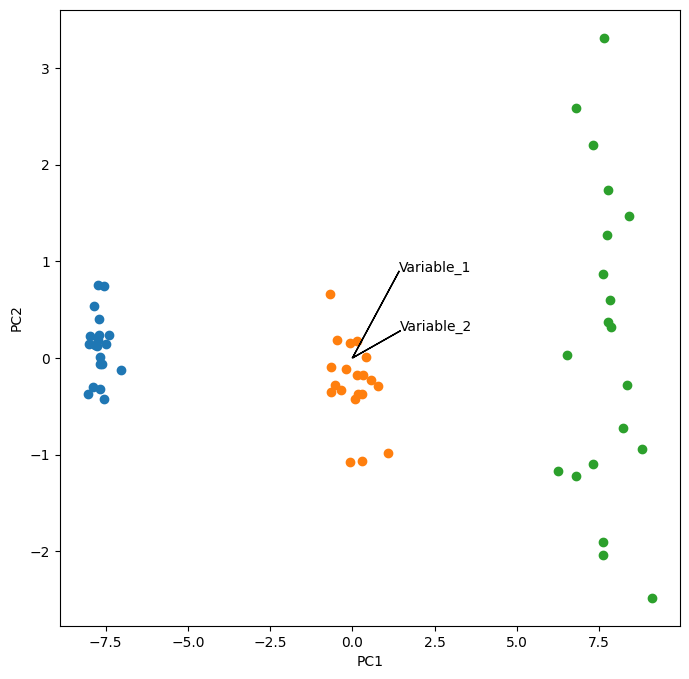

In [56]:
scale_arrow = 10
clases = np.array_split(scores, 3)

class_1 = clases[0]
class_2 = clases[1]
class_3 = clases[2]


# Define the number of components to plot
num_components_to_plot = 2

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(class_1[:, 0], class_1[:, 1])
ax.scatter(class_2[:, 0], class_2[:, 1])
ax.scatter(class_3[:, 0], class_3[:, 1])

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

# Plot arrows for the first two principal components
for k in range(num_components_to_plot):
    ax.arrow(0, 0, scale_arrow * pcaSD.components_[0, k], scale_arrow * pcaSD.components_[1, k])
    ax.text(scale_arrow * pcaSD.components_[0, k], scale_arrow * pcaSD.components_[1, k],
            simulated_data.columns[k])

plt.show()

# c)

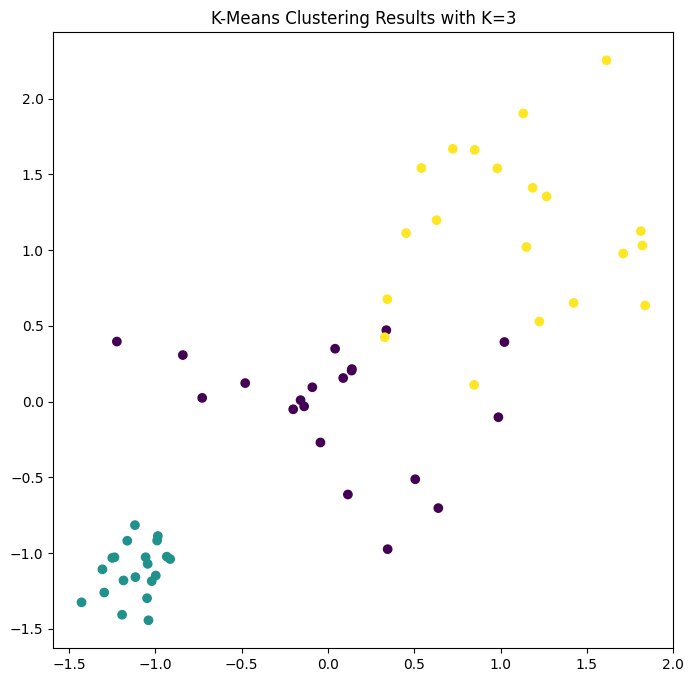

In [57]:
kmeans = KMeans(n_clusters=3,
                random_state=3,
                n_init=20).fit(simulated_data_scaled)
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(simulated_data_scaled[:,0], simulated_data_scaled[:,1], c=kmeans.labels_)
ax.set_title("K-Means Clustering Results with K=3");
